# Pipeline of Training and Evaluation Machine Learning Models

### Requirements

In [18]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from scipy.stats import multivariate_normal
from sklearn.neighbors import KernelDensity
from sklearn.utils import resample
from dataclasses import dataclass
from collections import Counter
from google.colab import drive
import matplotlib.pyplot as plt
from scipy.stats import norm
from pathlib import Path
from typing import List
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import pickle
import copy

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
model_path = "/content/drive/MyDrive/Aulas/AprendizadoDeMáquina/Projeto/Models"
data_path = "/content/drive/MyDrive/Aulas/AprendizadoDeMáquina/Projeto/Dataset/CrossValidation"
results_path = "/content/drive/MyDrive/Aulas/AprendizadoDeMáquina/Projeto/Results"

## Configurations

In [4]:
#@markdown ### Algoritmo:
selected_model = "LR" #@param ["GB", "PW", "KNN", "LR"]
model_options = ["GB"]
datasets = ["mfeat_fac", "mfeat_fou", "mfeat_zer"]
repeat_id_start = 1 # @param {type:"slider", min:1, max:30, step:1}
repeat_id_end = 30 # @param {type:"slider", min:1, max:30, step:1}
fold_id_start = 1 # @param {type:"slider", min:1, max:10, step:1}
fold_id_end = 10 # @param {type:"slider", min:1, max:10, step:1}

actual_model = None

### Models

In [5]:
@dataclass
class Model:
  model: any = None
  name: str = ""

  def params(self):
    pass

  def load_params(self):
    complete_path = f"{model_path}/{dataset_name}"
    with open(f'{complete_path}/best_params_{self.name}.pkl', 'rb') as f:
      loaded_best_params = pickle.load(f)
    self.model.set_params(**loaded_best_params)

  def run_hyper(self, x, y):
    grid_search = GridSearchCV(self.model, self.params(), cv=5, verbose=2)
    grid_search.fit(x, y)
    best_params = grid_search.best_params_
    print(best_params)
    self.model.set_params(**best_params)

    complete_path = f"{model_path}/{dataset_name}"
    path = Path(complete_path)
    path.mkdir(parents=True, exist_ok=True)

    with open(f'{complete_path}/best_params_{self.name}.pkl', 'wb') as f:
      pickle.dump(best_params, f)

  def load_model(self, dataset_name, repeat):
    state = joblib.load(f"{model_path}/{dataset_name}/{repeat}/{self.name}.pkl")
    self.model.__setstate__(state)

  def save_model(self, repeat):
    complete_path = f"{model_path}/{dataset_name}/{repeat}"
    path = Path(complete_path)
    path.mkdir(parents=True, exist_ok=True)

    model_state = self.model.__getstate__()

    _ = joblib.dump(model_state, f"{complete_path}/{self.name}.pkl", compress=4)

  def clear():
    if self.name=="GB":
      self.model.clear()

  def train(self, x, y, repeat):
    self.load_params()
    self.model.fit(x, y)
    self.save_model(repeat)
    self.clear()

  def test(self, x, dataset_name, repeat):
    self.load_model(dataset_name, repeat)
    return self.model.predict(x)

In [6]:
class GaussianBayesianClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.means = []
        self.covariances = []
        self.priors = []
        self.classes_ = []

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        for i in self.classes_:
            subset = X[y == i]
            self.means.append(np.mean(subset, axis=0))
            self.covariances.append(np.cov(subset, rowvar=False))
            self.priors.append(len(subset) / len(X))
        return self

    def predict(self, X):
        # Calcule as probabilidades a posteriori e retorne a classe com a maior probabilidade
        posterior_probs = []

        for i, c in enumerate(self.classes_):
            likelihood = multivariate_normal.pdf(X, mean=self.means[i], cov=self.covariances[i], allow_singular=True)
            posterior = likelihood * self.priors[i]
            posterior_probs.append(posterior)

        posterior_probs = np.array(posterior_probs).T
        predictions = self.classes_[np.argmax(posterior_probs, axis=1)]

        return predictions

    def clear(self):
      self.means = []
      self.covariances = []
      self.priors = []
      self.classes_ = []

@dataclass
class GaussianBayesianModel(Model):
  def __post_init__(self):
    self.model = GaussianBayesianClassifier()
    self.name = "GB"

  def params(self):
    return {}

In [7]:
@dataclass
class KNeighborsModel(Model):
  def __post_init__(self):
    #Inicializando o modelo KNN com a distância euclidiana
    self.model = KNN (metric='euclidean')
    #Definindo nome do modelo com KNN
    self.name = "KNN"

  def params(self):
    return {
        #Lista de números de vizinhos considerados pelo modelo
        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        #Lista com o peso dos vizinhos
        'weights': ['uniform', 'distance'],
        #Lista de algoritmos para computação dos vizinhos
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }

In [8]:
@dataclass
class LogisticRegressionModel(Model):
  def __post_init__(self):
    self.model = LR(multi_class='ovr')
    self.name = "LR"

  def params(self):
    return {
        'penalty': ["l1", "l2", "elasticnet", None],
        'C': [0.1, 1, 10, 100],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': [100, 200, 400],
        'fit_intercept': [True, False],
        'class_weight': [None, 'balanced']
    }

In [9]:
class ParzenWindowBayesianClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, h=1.0):
        self.h = h
        self.classes = None
        self.class_data = {}

    def fit(self, X, y):
        self.classes = np.unique(y)
        for c in self.classes:
            self.class_data[c] = X[y == c]

    def gaussian_pdf(self, x, mean):
        return norm.pdf(x, mean, self.h)

    def predict(self, X):
        X = X.values if isinstance(X, pd.DataFrame) else X
        predictions = []
        for x in X:
            posteriors = {}
            for c in self.classes:
                likelihood = 1.0
                for d in range(X.shape[1]):
                    x_value = float(x[d])
                    class_data_values = self.class_data[c].values[:, d].astype(float)

                    likelihood *= np.mean(self.gaussian_pdf(x_value, class_data_values))
                prior = len(self.class_data[c]) / len(X)
                posteriors[c] = prior * likelihood
            pred_class = max(posteriors, key=posteriors.get)
            predictions.append(pred_class)
        return np.array(predictions)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

    def __getstate__(self):
        return self.__dict__

    def __setstate__(self, state):
        self.__dict__.update(state)

@dataclass
class ParzenWindowModel(Model):
  def __post_init__(self):
    self.model = ParzenWindowBayesianClassifier()
    self.name = "PW"

  def params(self):
    return {
        'h': [0.001, 0.01, 0.1, 1, 10]
    }

In [10]:
storage_models = [
    GaussianBayesianModel(),
    KNeighborsModel(),
    LogisticRegressionModel(),
    ParzenWindowModel()
    ]

In [11]:
def selection_model(model_name):
  for model in storage_models:
    if model.name == model_name:
      actual_model = model
  print("Actual Model: ", actual_model)
  return actual_model

actual_model = selection_model(selected_model)

Actual Model:  LogisticRegressionModel(model=LogisticRegression(multi_class='ovr'), name='LR')


### Dataset

In [12]:
class Dataset:
  @staticmethod
  def get_hiper_sample(dataset_name: str):
    df = pd.read_csv(f"{data_path}/{dataset_name}/repeat1/split1/train_fold.csv")
    y = df.iloc[:, 0]
    x = df.iloc[:, 1:]
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
    return x_val, y_val

  @staticmethod
  def get_sample_per_repeat_and_fold(dataset_name: str, repead_id: int, fold_id: int, is_train: bool = True):
    split_type = "train_fold" if is_train else "test_fold"
    df = pd.read_csv(f"{data_path}/{dataset_name}/repeat{repead_id}/split{fold_id}/{split_type}.csv")
    y = df.iloc[:, 0]
    x = df.iloc[:, 1:]
    return x, y

### Save results

In [13]:
class SaveResults:

  @staticmethod
  def save_test_results(dataset_name, y_predicted, y_real, repetition, fold, isVC):

    accuracy = accuracy_score(y_real, y_predicted)
    f1 = f1_score(y_real, y_predicted, average='weighted')
    recall = recall_score(y_real, y_predicted, average='weighted')
    precision = precision_score(y_real, y_predicted, average='weighted')

    result_df = pd.DataFrame({
        'Model': [actual_model.name],
        'Dataset': [dataset_name],
        'Repetition': [repetition],
        'Fold': [fold],
        'Accuracy': [accuracy],
        'F1': [f1],
        'Recall': [recall],
        'Precision': [precision]
    })

    if isVC:
      filename="results_vc"
    else:
      filename="results"

    try:
        existing_df = pd.read_csv(f"{results_path}/{filename}.csv")
        result_df = pd.concat([existing_df, result_df], ignore_index=True)
    except FileNotFoundError:
        pass

    result_df.to_csv(f"{results_path}/{filename}.csv", index=False)

## Hyperparametrization (Grid Search)

In [ ]:
for dataset in datasets:
  dataset_name = dataset

  x, y = Dataset.get_hiper_sample(dataset_name)
  actual_model.run_hyper(x, y)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
{}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
{}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] EN

## Train

In [ ]:
for dataset in datasets:
  dataset_name = dataset

  for repeat in range(repeat_id_start, repeat_id_end + 1):
    for fold in range(fold_id_start, fold_id_end + 1):
      print(f"Repeat: {repeat}, Fold: {fold}")
      x, y = Dataset.get_sample_per_repeat_and_fold(dataset_name, repeat, fold)
      actual_model.train(x, y, repeat)

Repeat: 1, Fold: 1
Repeat: 1, Fold: 2
Repeat: 1, Fold: 3
Repeat: 1, Fold: 4
Repeat: 1, Fold: 5
Repeat: 1, Fold: 6
Repeat: 1, Fold: 7
Repeat: 1, Fold: 8
Repeat: 1, Fold: 9
Repeat: 1, Fold: 10
Repeat: 2, Fold: 1
Repeat: 2, Fold: 2
Repeat: 2, Fold: 3
Repeat: 2, Fold: 4
Repeat: 2, Fold: 5
Repeat: 2, Fold: 6
Repeat: 2, Fold: 7
Repeat: 2, Fold: 8
Repeat: 2, Fold: 9
Repeat: 2, Fold: 10
Repeat: 3, Fold: 1
Repeat: 3, Fold: 2
Repeat: 3, Fold: 3
Repeat: 3, Fold: 4
Repeat: 3, Fold: 5
Repeat: 3, Fold: 6
Repeat: 3, Fold: 7
Repeat: 3, Fold: 8
Repeat: 3, Fold: 9
Repeat: 3, Fold: 10
Repeat: 4, Fold: 1
Repeat: 4, Fold: 2
Repeat: 4, Fold: 3
Repeat: 4, Fold: 4
Repeat: 4, Fold: 5
Repeat: 4, Fold: 6
Repeat: 4, Fold: 7
Repeat: 4, Fold: 8
Repeat: 4, Fold: 9
Repeat: 4, Fold: 10
Repeat: 5, Fold: 1
Repeat: 5, Fold: 2
Repeat: 5, Fold: 3
Repeat: 5, Fold: 4
Repeat: 5, Fold: 5
Repeat: 5, Fold: 6
Repeat: 5, Fold: 7
Repeat: 5, Fold: 8
Repeat: 5, Fold: 9
Repeat: 5, Fold: 10
Repeat: 6, Fold: 1
Repeat: 6, Fold: 2
Repeat:

## Test

In [15]:
for select_model in model_options:
  actual_model = selection_model(select_model)

  for dataset in datasets:
    dataset_name = dataset

    for repeat in range(repeat_id_start, repeat_id_end + 1):
      for fold in range(fold_id_start, fold_id_end + 1):
        print(f"Repeat: {repeat}, Fold: {fold}")
        x, y = Dataset.get_sample_per_repeat_and_fold(dataset_name, repeat, fold, is_train=False)
        y_predicted = actual_model.test(x, dataset_name, repeat)
        SaveResults.save_test_results(dataset_name, y_predicted, y, repeat, fold, False)

Actual Model:  GaussianBayesianModel(model=GaussianBayesianClassifier(), name='GB')
Repeat: 1, Fold: 1
Repeat: 1, Fold: 2
Repeat: 1, Fold: 3
Repeat: 1, Fold: 4
Repeat: 1, Fold: 5
Repeat: 1, Fold: 6
Repeat: 1, Fold: 7
Repeat: 1, Fold: 8
Repeat: 1, Fold: 9
Repeat: 1, Fold: 10
Repeat: 2, Fold: 1
Repeat: 2, Fold: 2
Repeat: 2, Fold: 3
Repeat: 2, Fold: 4
Repeat: 2, Fold: 5
Repeat: 2, Fold: 6
Repeat: 2, Fold: 7
Repeat: 2, Fold: 8
Repeat: 2, Fold: 9
Repeat: 2, Fold: 10
Repeat: 3, Fold: 1
Repeat: 3, Fold: 2
Repeat: 3, Fold: 3
Repeat: 3, Fold: 4
Repeat: 3, Fold: 5
Repeat: 3, Fold: 6
Repeat: 3, Fold: 7
Repeat: 3, Fold: 8
Repeat: 3, Fold: 9
Repeat: 3, Fold: 10
Repeat: 4, Fold: 1
Repeat: 4, Fold: 2
Repeat: 4, Fold: 3
Repeat: 4, Fold: 4
Repeat: 4, Fold: 5
Repeat: 4, Fold: 6
Repeat: 4, Fold: 7
Repeat: 4, Fold: 8
Repeat: 4, Fold: 9
Repeat: 4, Fold: 10
Repeat: 5, Fold: 1
Repeat: 5, Fold: 2
Repeat: 5, Fold: 3
Repeat: 5, Fold: 4
Repeat: 5, Fold: 5
Repeat: 5, Fold: 6
Repeat: 5, Fold: 7
Repeat: 5, Fold: 8


## Ensemble Models

In [16]:
class VotingClassifierModel:
  def __init__(self, model: Model, repeat, fold):
    models = []
    self.x_datas = []

    for dataset in datasets:
        x, self.y = Dataset.get_sample_per_repeat_and_fold(dataset, repeat, fold, is_train=False)
        self.x_datas.append(x)
        model.load_model(dataset, repeat)
        models.append(copy.deepcopy(model))

    self.models = [model.model for model in models]

  def test(self):
        assert len(self.models) == len(datasets), "Número de modelos e datasets deve ser o mesmo."

        predictions = []

        # Coleta previsões de cada modelo
        for model, dataset in zip(self.models, self.x_datas):
            pred = model.predict(dataset)
            predictions.append(pred)

        # Realiza um voto majoritário
        stacked_predictions = np.column_stack([pred.astype(int) for pred in predictions])
        majority_vote = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=stacked_predictions)

        return majority_vote, self.y

In [17]:
for select_model in model_options:
  actual_model = selection_model(select_model)

  for repeat in range(repeat_id_start, repeat_id_end + 1):
    for fold in range(fold_id_start, fold_id_end + 1):
      print(f"Repeat: {repeat}, Fold: {fold}")
      y_predicted, y = VotingClassifierModel(actual_model, repeat, fold).test()
      SaveResults.save_test_results(str(datasets), y_predicted, y, repeat, fold, True)

Actual Model:  GaussianBayesianModel(model=GaussianBayesianClassifier(), name='GB')
Repeat: 1, Fold: 1
Repeat: 1, Fold: 2
Repeat: 1, Fold: 3
Repeat: 1, Fold: 4
Repeat: 1, Fold: 5
Repeat: 1, Fold: 6
Repeat: 1, Fold: 7
Repeat: 1, Fold: 8
Repeat: 1, Fold: 9
Repeat: 1, Fold: 10
Repeat: 2, Fold: 1
Repeat: 2, Fold: 2
Repeat: 2, Fold: 3
Repeat: 2, Fold: 4
Repeat: 2, Fold: 5
Repeat: 2, Fold: 6
Repeat: 2, Fold: 7
Repeat: 2, Fold: 8
Repeat: 2, Fold: 9
Repeat: 2, Fold: 10
Repeat: 3, Fold: 1
Repeat: 3, Fold: 2
Repeat: 3, Fold: 3
Repeat: 3, Fold: 4
Repeat: 3, Fold: 5
Repeat: 3, Fold: 6
Repeat: 3, Fold: 7
Repeat: 3, Fold: 8
Repeat: 3, Fold: 9
Repeat: 3, Fold: 10
Repeat: 4, Fold: 1
Repeat: 4, Fold: 2
Repeat: 4, Fold: 3
Repeat: 4, Fold: 4
Repeat: 4, Fold: 5
Repeat: 4, Fold: 6
Repeat: 4, Fold: 7
Repeat: 4, Fold: 8
Repeat: 4, Fold: 9
Repeat: 4, Fold: 10
Repeat: 5, Fold: 1
Repeat: 5, Fold: 2
Repeat: 5, Fold: 3
Repeat: 5, Fold: 4
Repeat: 5, Fold: 5
Repeat: 5, Fold: 6
Repeat: 5, Fold: 7
Repeat: 5, Fold: 8


## Confidence Interval

#### Check Dataframe [Optional]

In [20]:
results_df = pd.read_csv(f"{results_path}/results.csv")
results_vc_df = pd.read_csv(f"{results_path}/results_vc.csv")

In [21]:
duplicate = results_df[results_df.duplicated()]
print("Duplicate Rows in Results:")
print(duplicate)

duplicate = results_vc_df[results_vc_df.duplicated()]
print("Duplicate Rows in Results VotingClassifier:")
print(duplicate)

Duplicate Rows in Results:
Empty DataFrame
Columns: [Model, Dataset, Repetition, Fold, Accuracy, F1, Recall, Precision]
Index: []
Duplicate Rows in Results VotingClassifier:
    Model                                  Dataset  Repetition  Fold  \
758    PW  ['mfeat_fac', 'mfeat_fou', 'mfeat_zer']          16     1   
759    PW  ['mfeat_fac', 'mfeat_fou', 'mfeat_zer']          16     2   
760    PW  ['mfeat_fac', 'mfeat_fou', 'mfeat_zer']          16     3   
761    PW  ['mfeat_fac', 'mfeat_fou', 'mfeat_zer']          16     4   
762    PW  ['mfeat_fac', 'mfeat_fou', 'mfeat_zer']          16     5   
763    PW  ['mfeat_fac', 'mfeat_fou', 'mfeat_zer']          16     6   
764    PW  ['mfeat_fac', 'mfeat_fou', 'mfeat_zer']          16     7   
765    PW  ['mfeat_fac', 'mfeat_fou', 'mfeat_zer']          16     8   

     Accuracy        F1  Recall  Precision  
758     0.955  0.954040   0.955   0.956183  
759     0.925  0.921468   0.925   0.924465  
760     0.955  0.954158   0.955   0.956659

In [22]:
results_df = results_df.drop_duplicates()
results_vc_df = results_vc_df.drop_duplicates()

results_df.to_csv(f"{results_path}/results_cleaned.csv")
results_vc_df.to_csv(f"{results_path}/results_vc_cleaned.csv")

### Plot Confidence Interval

In [23]:
# Função para calcular o intervalo de confiança usando bootstrap
def bootstrap_ci(data, n_bootstrap=1000, alpha=0.05):
    """Calcula o intervalo de confiança usando o método bootstrap."""
    bootstrapped_means = [resample(data).mean() for _ in range(n_bootstrap)]
    lower = np.percentile(bootstrapped_means, alpha * 100 / 2)
    upper = np.percentile(bootstrapped_means, 100 - alpha * 100 / 2)
    return lower, upper

# Dicionários para armazenar os resultados
ci_results = {}
ci_results_vc = {}

# Lista de métricas para calcular o intervalo de confiança
metrics = ['Accuracy', 'F1', 'Recall', 'Precision']

# Calcular o intervalo de confiança para cada métrica, modelo e conjunto de dados no primeiro dataset
for model in results_df['Model'].unique():
    for dataset in results_df['Dataset'].unique():
        for metric in metrics:
            data = results_df[(results_df['Model'] == model) & (results_df['Dataset'] == dataset)][metric]
            lower, upper = bootstrap_ci(data)
            ci_results[(model, dataset, metric)] = (lower, upper)

# Calcular o intervalo de confiança para cada métrica, modelo e conjunto de dados no segundo dataset
for model in results_vc_df['Model'].unique():
    for dataset in results_vc_df['Dataset'].unique():
        for metric in metrics:
            data = results_vc_df[(results_vc_df['Model'] == model) & (results_vc_df['Dataset'] == dataset)][metric]
            lower, upper = bootstrap_ci(data)
            ci_results_vc[(model, dataset, metric)] = (lower, upper)

In [24]:
# Preparar os dados para plotagem
plot_data = []
plot_data_vc = []

for (model, dataset, metric), (lower, upper) in ci_results.items():
    mean = (lower + upper) / 2
    err = (upper - lower) / 2
    plot_data.append([model, dataset, metric, mean, err])

for (model, dataset, metric), (lower, upper) in ci_results_vc.items():
    mean = (lower + upper) / 2
    err = (upper - lower) / 2
    plot_data_vc.append([model, dataset, metric, mean, err])


plot_df = pd.DataFrame(plot_data, columns=['Model', 'Dataset', 'Metric', 'Mean', 'Error'])
plot_df_vc = pd.DataFrame(plot_data_vc, columns=['Model', 'Dataset', 'Metric', 'Mean', 'Error'])

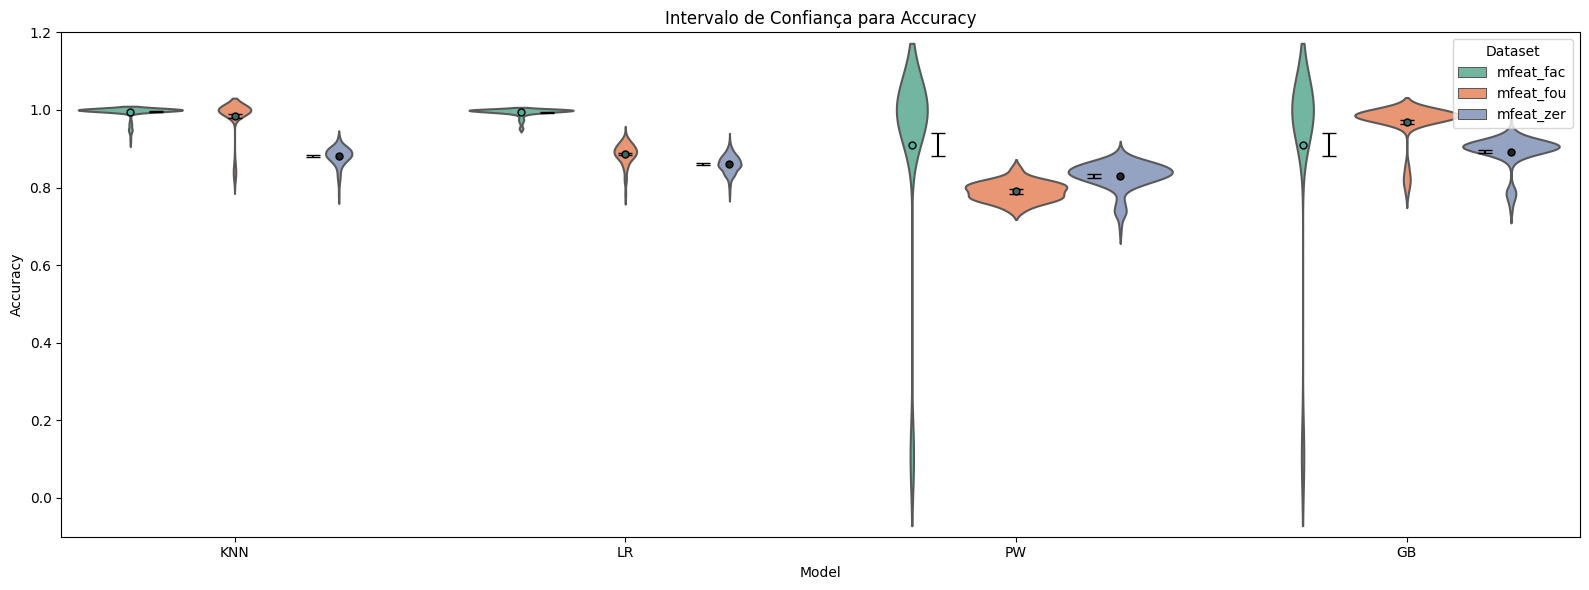

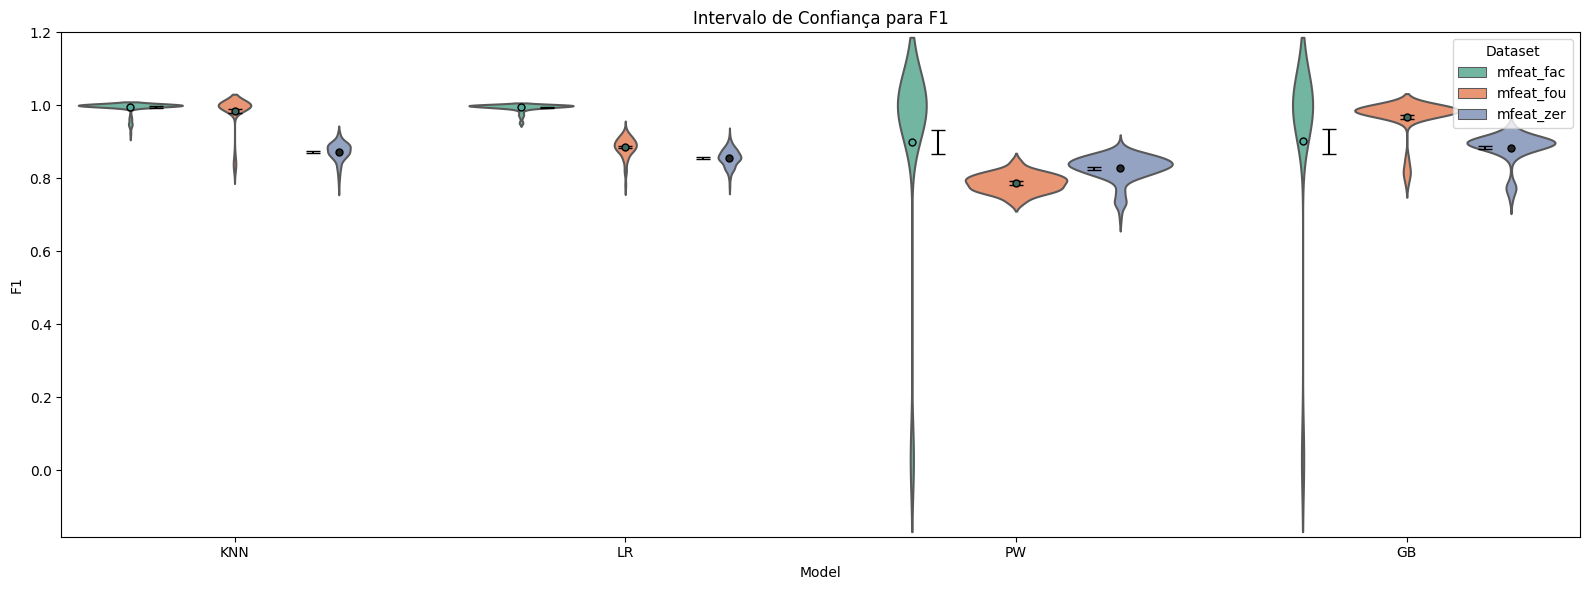

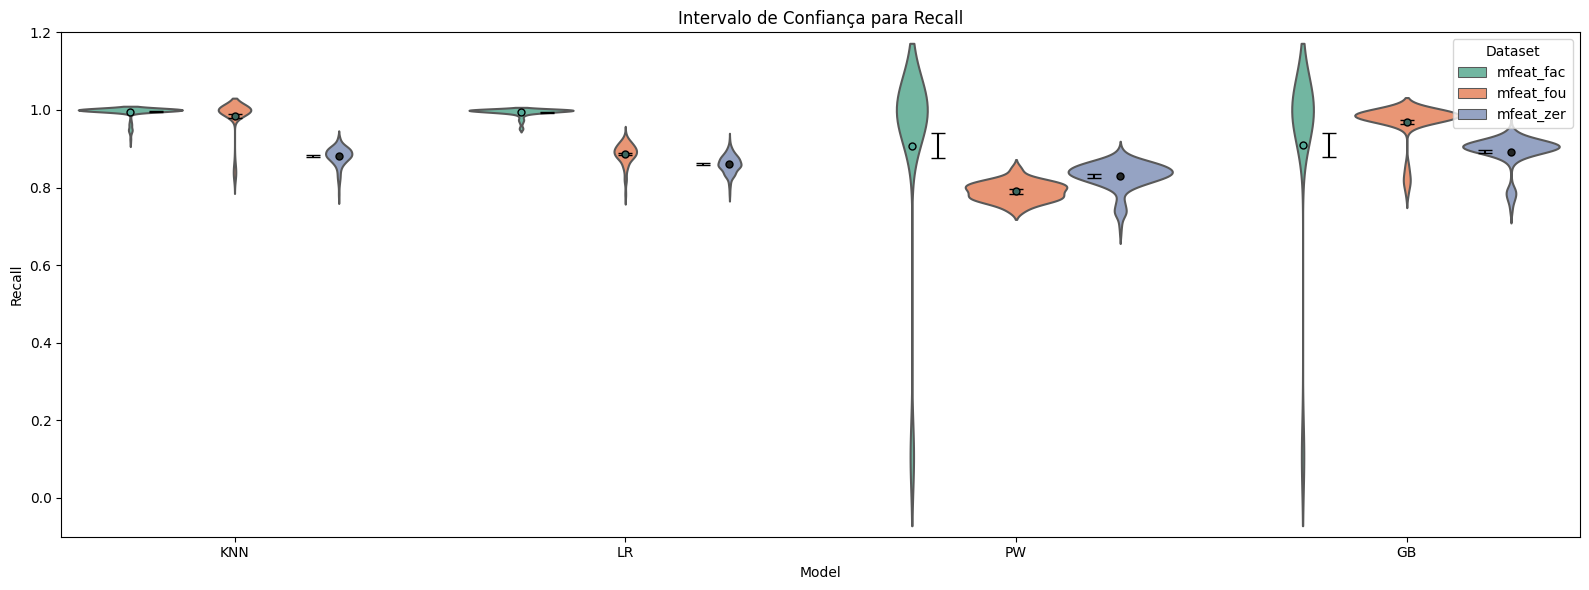

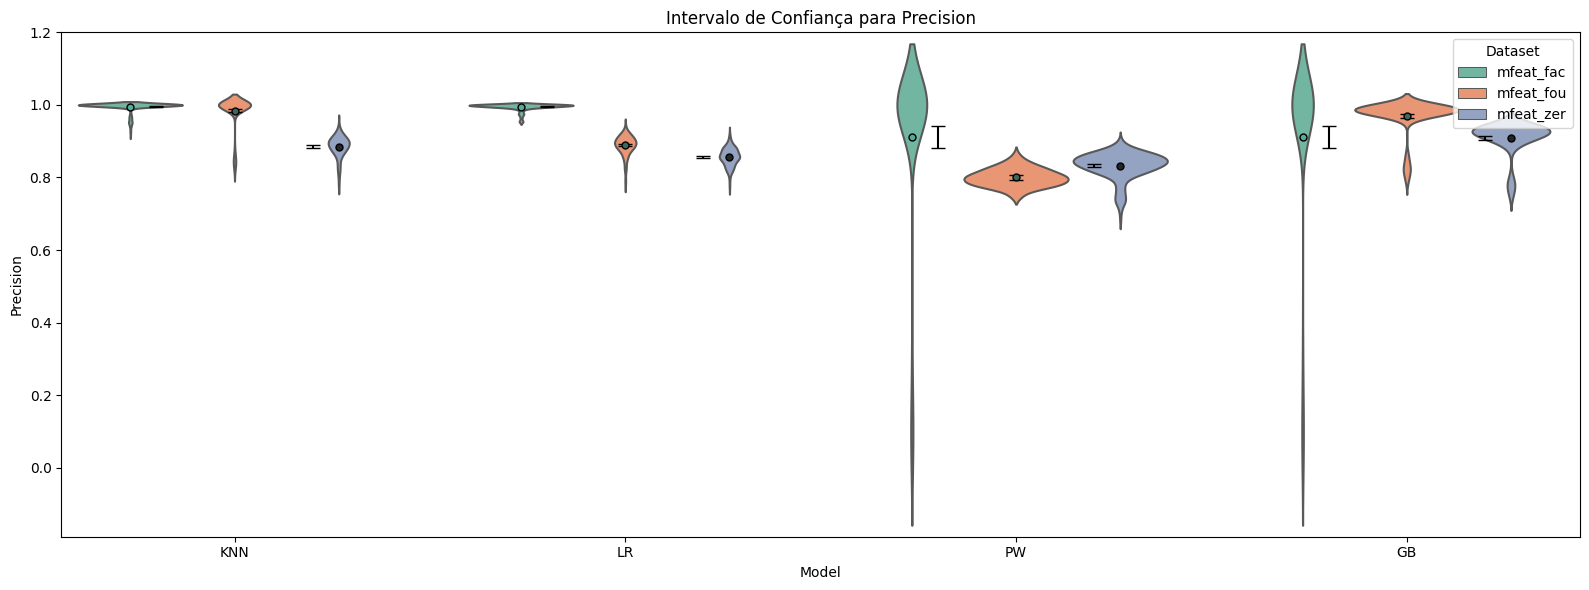

In [31]:
# Função para plotar os gráficos de violino com intervalos de confiança para múltiplos modelos em um único gráfico
def plot_combined_violin(dataframe, original_data, metrics):
    for metric in metrics:
        plt.figure(figsize=(16, 6))

        ax = sns.violinplot(x='Model', y=metric, hue='Dataset', data=original_data,
                            inner=None, alpha=0.7, palette="Set2")

        sns.swarmplot(x='Model', y='Mean', hue='Dataset', data=dataframe[dataframe['Metric'] == metric],
                      dodge=True, marker='o', edgecolor='black', linewidth=1, palette="dark:#5A9_r")

        y_min = original_data[metric].min() - 0.2
        y_max = original_data[metric].max() + 0.2
        ax.set_ylim(y_min, y_max)

        # Adicionando as barras de erro para o intervalo de confiança
        for i, model in enumerate(dataframe['Model'].unique()):
            for j, dataset in enumerate(dataframe['Dataset'].unique()):
                subset = dataframe[(dataframe['Model'] == model) & (dataframe['Dataset'] == dataset) & (dataframe['Metric'] == metric)]
                if subset.shape[0] > 0:
                    mean = subset['Mean'].values[0]
                    err = subset['Error'].values[0]
                    position = i + 0.2 * (j - 1)  # Ajuste da posição para se alinhar com as barras
                    plt.errorbar(x=[position], y=[mean], yerr=[err], fmt='none', capsize=5, color='black')

        # Removendo as legendas duplicadas
        handles, labels = ax.get_legend_handles_labels()
        l = plt.legend(handles[0:len(dataframe['Dataset'].unique())], labels[0:len(dataframe['Dataset'].unique())], title="Dataset")

        plt.title(f'Intervalo de Confiança para {metric}')
        plt.tight_layout()
        plt.show()
# Plotar os gráficos de violino para o Dataset 1 com todos os modelos em um único gráfico para cada métrica
plot_combined_violin(plot_df, results_df, metrics)

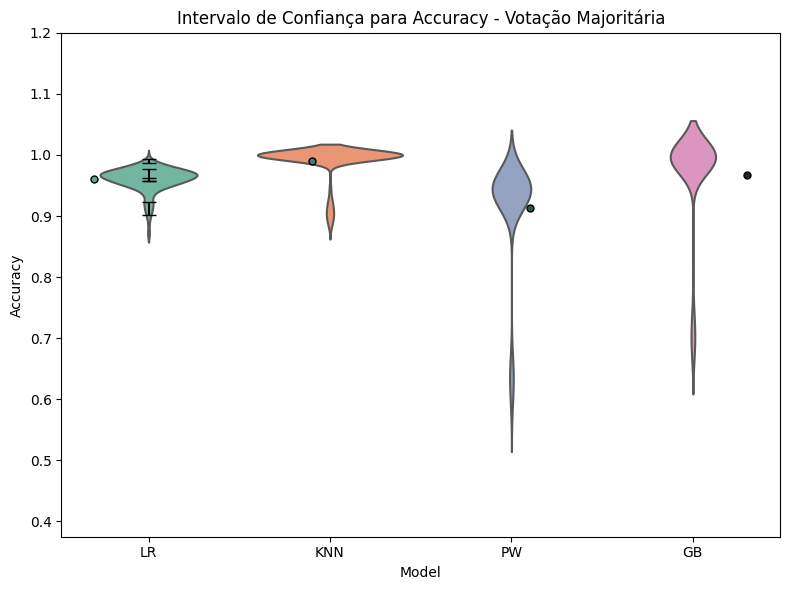

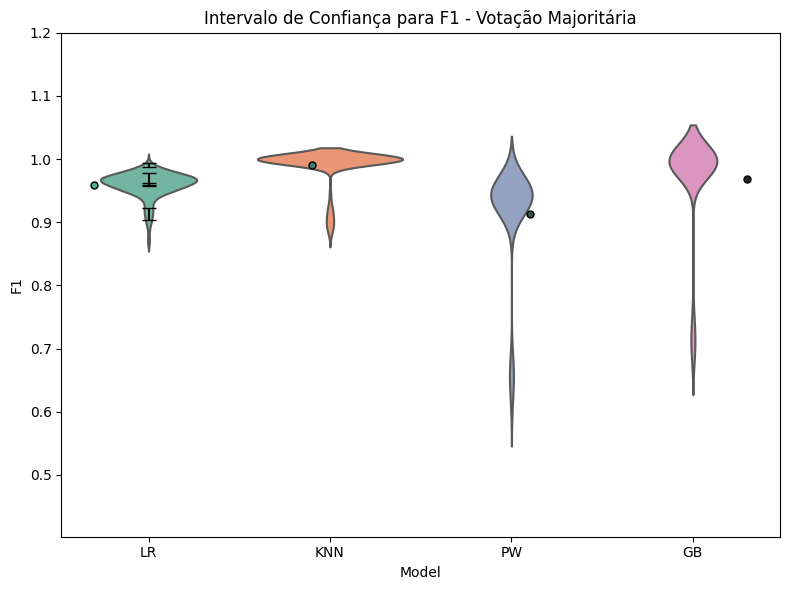

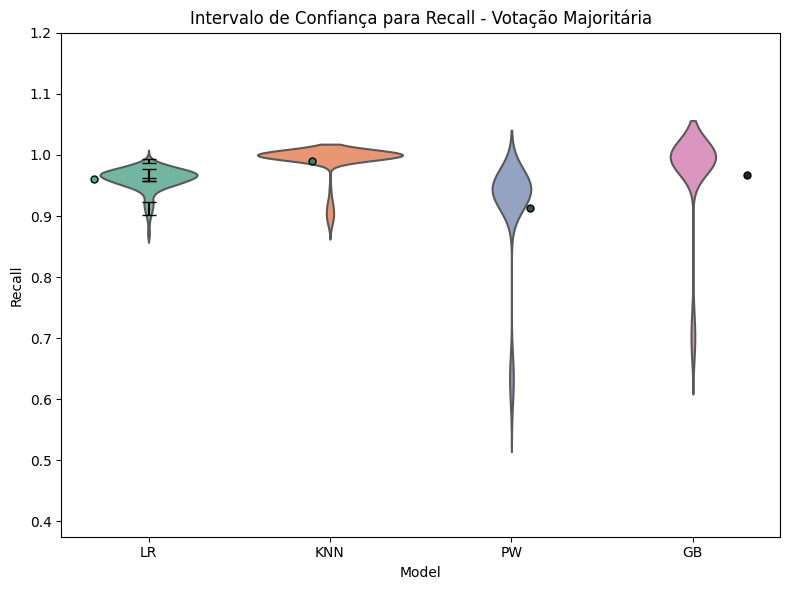

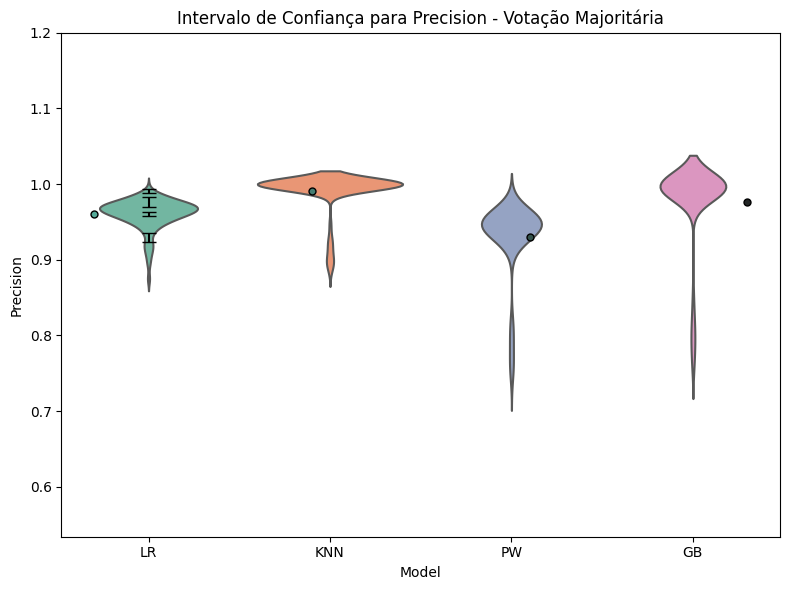

In [32]:
# Função para plotar o gráfico de violino para o dataset de votação majoritária
def plot_voting_violin(dataframe, original_data, metrics):
    for metric in metrics:
        plt.figure(figsize=(8, 6))

        ax = sns.violinplot(x='Model', y=metric, data=original_data,
                            inner=None, alpha=0.7, palette="Set2")

        sns.swarmplot(x='Model', y='Mean', data=dataframe[dataframe['Metric'] == metric],
                      dodge=True, marker='o', edgecolor='black', linewidth=1, palette="dark:#5A9_r")

        y_min = original_data[metric].min() - 0.2
        y_max = original_data[metric].max() + 0.2
        ax.set_ylim(y_min, y_max)

        # Adicionando as barras de erro para o intervalo de confiança
        for model in dataframe['Model'].unique():
            subset = dataframe[(dataframe['Model'] == model) & (dataframe['Metric'] == metric)]
            if subset.shape[0] > 0:
                mean = subset['Mean'].values[0]
                err = subset['Error'].values[0]
                plt.errorbar(x=[0], y=[mean], yerr=[err], fmt='none', capsize=5, color='black')

        plt.title(f'Intervalo de Confiança para {metric} - Votação Majoritária')
        plt.tight_layout()
        plt.show()

# Plotar o gráfico de violino para o Dataset de Votação Majoritária
plot_voting_violin(plot_df_vc, results_vc_df, metrics)